In [1]:
!pip install mmengine
import torch
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from timm.models.registry import register_model
from timm.models.vision_transformer import _cfg
from mmengine.runner import load_checkpoint
from functools import partial

import math
import matplotlib.pyplot as plt

import os
import cv2
import numpy as np
import random
import glob

import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.1/450.1 kB 7.7 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
DATASET_DIRECTORY = '/kaggle/input/monocular-depth-estimation/val/indoors'

dataset = {}
for subdir, dirs, files in os.walk(DATASET_DIRECTORY):
  for file in files:
    basename = os.path.basename(os.path.join(subdir, file))
    if basename[-3:] == "png":
      basename = basename[:-4]
      kind = "rgb"
    elif basename[-9:] == "depth.npy":
      basename = basename[:-10]
      kind = "depth"
    elif basename[-14:] == "depth_mask.npy":
      basename = basename[:-15]
      kind = "mask"
    else:
      continue

    if not basename in dataset:
      dataset[basename] = { "rgb": None, "depth": None, "mask": None }
    dataset[basename][kind] = os.path.join(subdir, file)

In [3]:
class DIODEDataset(Dataset):
    def __init__(self, img_size=256, batch_size = 16, num_workers=0):
        super(Dataset, self).__init__()
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_workers = num_workers
        self.keys = list(dataset.keys())
        
    def __len__(self):
        return len(dataset)
    
    @staticmethod
    def normalize(img):
        return (img * 2) - 1
    
    @staticmethod
    def denormalize(img):
        return (img + 1) / 2

    def __getitem__(self, idx):
        name = self.keys[idx]
        
        rgb = Image.open(dataset[name]['rgb'])
        rgb = np.array(rgb)
        rgb = ((rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb)))
        rgb = rgb.astype(np.float32)
        
        depth = dataset[name]["depth"]
        depth = np.load(depth).squeeze()

        mask = dataset[name]["mask"]
        mask = np.load(mask)
        mask = mask > 0

        max_depth = min(300, np.percentile(depth, 99))
        depth = np.clip(depth, 0.1, max_depth)
        depth = np.log(depth, where=mask)
        depth = np.ma.masked_where(~mask, depth)
        depth = np.clip(depth, 0.1, np.log(max_depth))
        depth = np.expand_dims(depth, axis=2)
        depth = ((depth - np.min(depth)) / (np.max(depth) - np.min(depth)))
        depth = depth.astype(np.float32)
        
        rgb, depth = torch.from_numpy(rgb), torch.from_numpy(depth)
        rgb, depth = rgb.permute(2, 0, 1), depth.permute(2, 0, 1)
        rgb = transforms.Resize((256, 256))(rgb)
        depth = transforms.Resize((256, 256))(depth)
        
        return rgb, depth

In [4]:
class SelectiveFeatureFusion(nn.Module):
    def __init__(self, in_channel=64):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=int(in_channel*2),
                      out_channels=in_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_channel),
            nn.ReLU())

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=in_channel, 
                      out_channels=int(in_channel / 2), kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(int(in_channel / 2)),
            nn.ReLU())

        self.conv3 = nn.Conv2d(in_channels=int(in_channel / 2), 
                               out_channels=2, kernel_size=3, stride=1, padding=1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x_local, x_global):
        x = torch.cat((x_local, x_global), dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        attn = self.sigmoid(x)

        out = x_local * attn[:, 0, :, :].unsqueeze(1) + \
              x_global * attn[:, 1, :, :].unsqueeze(1)

        return out

In [5]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.bot_conv = nn.Conv2d(
            in_channels=in_channels[0], out_channels=out_channels, kernel_size=1)
        self.skip_conv1 = nn.Conv2d(
            in_channels=in_channels[1], out_channels=out_channels, kernel_size=1)
        self.skip_conv2 = nn.Conv2d(
            in_channels=in_channels[2], out_channels=out_channels, kernel_size=1)

        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        
        self.fusion1 = SelectiveFeatureFusion(out_channels)
        self.fusion2 = SelectiveFeatureFusion(out_channels)
        self.fusion3 = SelectiveFeatureFusion(out_channels)

    def forward(self, x_1, x_2, x_3, x_4):
        x_4_ = self.bot_conv(x_4)
        out = self.up(x_4_)

        x_3_ = self.skip_conv1(x_3)
        out = self.fusion1(x_3_, out)
        out = self.up(out)

        x_2_ = self.skip_conv2(x_2)
        out = self.fusion2(x_2_, out)
        out = self.up(out)

        out = self.fusion3(x_1, out)
        out = self.up(out)
        out = self.up(out)

        return out

In [6]:
class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W)
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x

In [7]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = self.fc1(x)
        x = self.dwconv(x, H, W)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [8]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., sr_ratio=1):
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."

        self.dim = dim
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.kv = nn.Linear(dim, dim * 2, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv2d(
                dim, dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        B, N, C = x.shape
        q = self.q(x).reshape(B, N, self.num_heads, C //
                              self.num_heads).permute(0, 2, 1, 3)

        if self.sr_ratio > 1:
            x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
            x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
            x_ = self.norm(x_)
            kv = self.kv(x_).reshape(B, -1, 2, self.num_heads,
                                     C // self.num_heads).permute(2, 0, 3, 1, 4)
        else:
            kv = self.kv(x).reshape(B, -1, 2, self.num_heads, C //
                                    self.num_heads).permute(2, 0, 3, 1, 4)
        k, v = kv[0], kv[1]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x

In [9]:
class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, sr_ratio=sr_ratio)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(
            drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim,
                       act_layer=act_layer, drop=drop)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = x + self.drop_path(self.attn(self.norm1(x), H, W))
        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))

        return x

In [10]:
class OverlapPatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W

In [11]:
class MixVisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dims=[64, 128, 256, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1]):
        super().__init__()
        self.num_classes = num_classes
        self.depths = depths

        # patch_embed
        self.patch_embed1 = OverlapPatchEmbed(img_size=img_size, patch_size=7, stride=4, in_chans=in_chans,
                                              embed_dim=embed_dims[0])
        self.patch_embed2 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1])
        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2])
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 16, patch_size=3, stride=2, in_chans=embed_dims[2],
                                              embed_dim=embed_dims[3])

        # transformer encoder
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate,
                                                sum(depths))]  # stochastic depth decay rule
        cur = 0
        self.block1 = nn.ModuleList([Block(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=mlp_ratios[0], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur +
                                                                    i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])
            for i in range(depths[0])])
        self.norm1 = norm_layer(embed_dims[0])

        cur += depths[0]
        self.block2 = nn.ModuleList([Block(
            dim=embed_dims[1], num_heads=num_heads[1], mlp_ratio=mlp_ratios[1], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur +
                                                                    i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[1])
            for i in range(depths[1])])
        self.norm2 = norm_layer(embed_dims[1])

        cur += depths[1]
        self.block3 = nn.ModuleList([Block(
            dim=embed_dims[2], num_heads=num_heads[2], mlp_ratio=mlp_ratios[2], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur +
                                                                    i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[2])
            for i in range(depths[2])])
        self.norm3 = norm_layer(embed_dims[2])

        cur += depths[2]
        self.block4 = nn.ModuleList([Block(
            dim=embed_dims[3], num_heads=num_heads[3], mlp_ratio=mlp_ratios[3], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur +
                                                                    i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[3])
            for i in range(depths[3])])
        self.norm4 = norm_layer(embed_dims[3])

        # classification head
        # self.head = nn.Linear(embed_dims[3], num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def init_weights(self, pretrained=None):
        if isinstance(pretrained, str):
            logger = get_root_logger()
            load_checkpoint(self, pretrained, map_location='cpu',
                            strict=False, logger=logger)

    def reset_drop_path(self, drop_path_rate):
        dpr = [x.item() for x in torch.linspace(
            0, drop_path_rate, sum(self.depths))]
        cur = 0
        for i in range(self.depths[0]):
            self.block1[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[0]
        for i in range(self.depths[1]):
            self.block2[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[1]
        for i in range(self.depths[2]):
            self.block3[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[2]
        for i in range(self.depths[3]):
            self.block4[i].drop_path.drop_prob = dpr[cur + i]

    def freeze_patch_emb(self):
        self.patch_embed1.requires_grad = False

    @torch.jit.ignore
    def no_weight_decay(self):
        # has pos_embed may be better
        return {'pos_embed1', 'pos_embed2', 'pos_embed3', 'pos_embed4', 'cls_token'}

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(
            self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]
        outs = []

        # stage 1
        x, H, W = self.patch_embed1(x)
        for i, blk in enumerate(self.block1):
            x = blk(x, H, W)
        x = self.norm1(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 2
        x, H, W = self.patch_embed2(x)
        for i, blk in enumerate(self.block2):
            x = blk(x, H, W)
        x = self.norm2(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 3
        x, H, W = self.patch_embed3(x)
        for i, blk in enumerate(self.block3):
            x = blk(x, H, W)
        x = self.norm3(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 4
        x, H, W = self.patch_embed4(x)
        for i, blk in enumerate(self.block4):
            x = blk(x, H, W)
        x = self.norm4(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        return outs

    def forward(self, x):
        x = self.forward_features(x)

        return x

In [12]:
class mit_b0(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b0, self).__init__(
            patch_size=4, embed_dims=[32, 64, 160, 256], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)


class mit_b1(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b1, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[2, 2, 2, 2], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)


class mit_b2(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b2, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)


class mit_b3(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b3, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 4, 18, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)


class mit_b4(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b4, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 8, 27, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)


class mit_b5(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b5, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 6, 40, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)

In [13]:
class Model(nn.Module):
    def __init__(self, max_depth=10.0):
        super().__init__()
        self.max_depth = max_depth

        self.encoder = mit_b4()

        channels_in = [512, 320, 128]
        channels_out = 64
            
        self.decoder = Decoder(channels_in, channels_out)
    
        self.last_layer_depth = nn.Sequential(
            nn.Conv2d(channels_out, channels_out, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=False),
            nn.Conv2d(channels_out, 1, kernel_size=3, stride=1, padding=1))

    def forward(self, x):                
        conv1, conv2, conv3, conv4 = self.encoder(x)
        out = self.decoder(conv1, conv2, conv3, conv4)
        out_depth = self.last_layer_depth(out)
        out_depth = torch.sigmoid(out_depth) * self.max_depth

        return {'pred': out_depth}

In [14]:
def gen_images():
    for batch_idx, batch in enumerate(train_loader):      
        input_RGB, depth_gt = batch
        input_RGB, depth_gt = input_RGB.to(device), depth_gt.to(device)

        preds = model(input_RGB)
        
        for i in range(batch_size):
            rgb = input_RGB[i].cpu().permute(1, 2, 0)
            depth = depth_gt[i].cpu().permute(1, 2, 0)
            pred = preds['pred'][i].cpu().detach().permute(1, 2, 0)
            
            display_list = [rgb, depth, pred]
    
            for i in range(3):
               display_list[i] = display_list[i] * 0.5 + 0.5
            title = ['RGB Image', 'Depth Image', 'Predicted Image']


            plt.subplot(1, 3, 1)
            plt.title('RGB Image')
            plt.imshow(display_list[0])
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.title('Depth (Real) Image')
            plt.imshow(display_list[1][:,:,0], cmap='plasma')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.title('Depth (Estimated) Image')
            plt.imshow(display_list[2][:,:,0], cmap='plasma')
            plt.axis('off')

            plt.show()
        break

In [15]:
batch_size     = 8      
workers        = 8
max_depth      = 10.0
max_depth_eval = 10.0
min_depth_eval = 1e-3
num_epochs     = 25
learningRate   = 0.0001                      
decay_epoch    = int(round(0.6*num_epochs)) 
image_size     = 256 
crop_w, crop_h = 576, 488

In [16]:
%%capture
model = Model(max_depth=max_depth)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if device.type == "cpu":
    pass
else:
    model = torch.nn.DataParallel(model)
model.to(device)

In [17]:
class SiLogLoss(nn.Module):
    def __init__(self, lambd=0.5):
        super().__init__()
        self.lambd = lambd

    def forward(self, pred, target):
        valid_mask = (target > 0).detach()
        diff_log = torch.log(target[valid_mask]) - torch.log(pred[valid_mask])
        loss = torch.sqrt(torch.pow(diff_log, 2).mean() -
                          self.lambd * torch.pow(diff_log.mean(), 2))

        return loss

In [18]:
optimizer = optim.RMSprop(model.parameters(), learningRate)
criterion_d = SiLogLoss()

In [19]:
diode_dataset = DIODEDataset()
train_loader = DataLoader(diode_dataset, batch_size=batch_size, shuffle=True)

In [20]:
class AverageMeter():
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

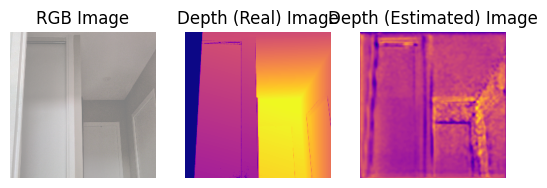

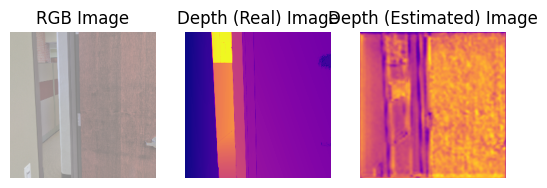

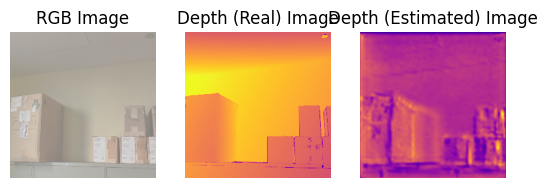

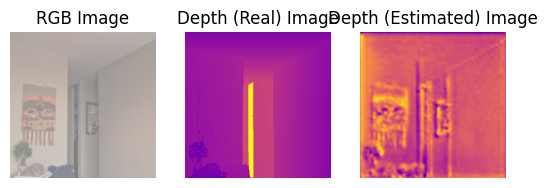

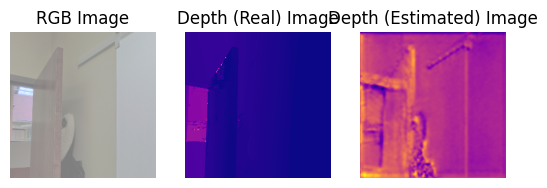

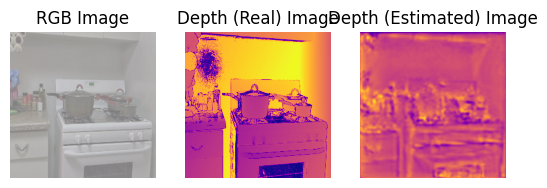

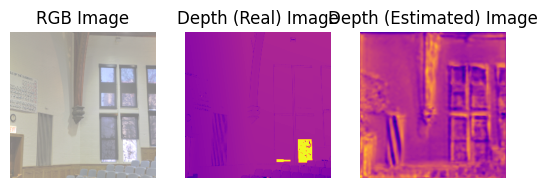

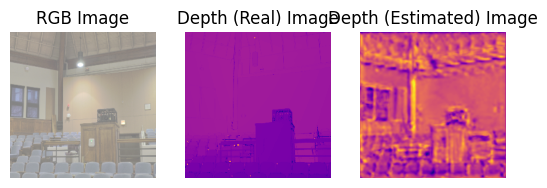

In [21]:
gen_images()

In [22]:
global_step = 0
def train(train_loader, model, criterion_d, optimizer, device, epoch):    
    global global_step
    model.train()
    depth_loss = AverageMeter()
    half_epoch = num_epochs // 2

    for batch_idx, batch in enumerate(train_loader):      
        global_step += 1

        for param_group in optimizer.param_groups:
            if global_step < 2019 * half_epoch:
                current_lr = (1e-4 - 3e-5) * (global_step /
                                              2019/half_epoch) ** 0.9 + 3e-5
            else:
                current_lr = (3e-5 - 1e-4) * (global_step /
                                              2019/half_epoch - 1) ** 0.9 + 1e-4
            param_group['lr'] = current_lr
        
        input_RGB, depth_gt = batch
        input_RGB, depth_gt = input_RGB.to(device), depth_gt.to(device)

        preds = model(input_RGB)

        optimizer.zero_grad()
        loss_d = criterion_d(preds['pred'], depth_gt)
        depth_loss.update(loss_d.item(), input_RGB.size(0))
        loss_d.backward()

        print("  STEP:", batch_idx, len(train_loader), num_epochs, epoch,
                            ('Depth Loss: %.4f (%.4f)' %
                            (depth_loss.val, depth_loss.avg)))
        optimizer.step()

    return loss_d

In [23]:
for epoch in range(1, num_epochs + 1):
    print('\nEpoch: %03d - %03d' % (epoch, num_epochs))
    loss_train = train(train_loader, model, criterion_d, optimizer=optimizer, 
                       device=device, epoch=epoch)


Epoch: 001 - 025
  STEP: 0 41 25 1 Depth Loss: 1.5443 (1.5443)
  STEP: 1 41 25 1 Depth Loss: 1.5612 (1.5528)
  STEP: 2 41 25 1 Depth Loss: 1.3032 (1.4696)
  STEP: 3 41 25 1 Depth Loss: 0.9642 (1.3432)
  STEP: 4 41 25 1 Depth Loss: 0.6232 (1.1992)
  STEP: 5 41 25 1 Depth Loss: 0.7726 (1.1281)
  STEP: 6 41 25 1 Depth Loss: 0.9367 (1.1008)
  STEP: 7 41 25 1 Depth Loss: 0.9127 (1.0772)
  STEP: 8 41 25 1 Depth Loss: 1.0676 (1.0762)
  STEP: 9 41 25 1 Depth Loss: 0.8000 (1.0486)
  STEP: 10 41 25 1 Depth Loss: 0.9692 (1.0413)
  STEP: 11 41 25 1 Depth Loss: 0.6220 (1.0064)
  STEP: 12 41 25 1 Depth Loss: 0.6857 (0.9817)
  STEP: 13 41 25 1 Depth Loss: 0.8210 (0.9702)
  STEP: 14 41 25 1 Depth Loss: 0.6363 (0.9480)
  STEP: 15 41 25 1 Depth Loss: 0.9545 (0.9484)
  STEP: 16 41 25 1 Depth Loss: 0.6451 (0.9306)
  STEP: 17 41 25 1 Depth Loss: 0.4860 (0.9059)
  STEP: 18 41 25 1 Depth Loss: 0.8134 (0.9010)
  STEP: 19 41 25 1 Depth Loss: 0.4562 (0.8788)
  STEP: 20 41 25 1 Depth Loss: 0.5917 (0.8651)
  STE

In [24]:
def calculate_psnr():
    psnrs = []
    
    for batch_idx, batch in enumerate(train_loader):      
        input_RGB, depth_gt = batch
        input_RGB, depth_gt = input_RGB.to(device), depth_gt.to(device)

        preds = model(input_RGB)
        
        for i in range(batch_size):
            rgb = input_RGB[i].cpu().numpy()
            depth = depth_gt[i].cpu().numpy()
            pred = preds['pred'][i].cpu().detach().numpy()
            
            psnr = cv2.PSNR(depth, pred)
            psnrs.append(psnr)
        break
    return np.mean(psnrs)

In [25]:
print("PSNR:", calculate_psnr())

PSNR: 59.366353165585295
